# Regresión de vectores de soporte (SVR)


# Librerias

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold , cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error , r2_score , mean_absolute_error , explained_variance_score
import warnings
warnings.filterwarnings("ignore")

# Datos

In [15]:
dfp=pd.read_csv(r'C:\Users\Juan Guzman\pviviendas\Data\dfanalisis')
dfp.head()

,tipo,precio,area,habitaciones,banos,garajes,balcon,trans. publico,estrato,antiguedad,...,zonas verdes,supermercado o cc,instalacion de gas,parqueadero visitantes,colegios / universidades,parques cercanos,zona residencial,closet,municipio,tipo_propiedad
0,0,1380000000,320.00,5,6.0,2,1.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro,casa
1,1,496122600,91.97,3,3.0,1,1.0,1.0,3.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro,apartamento
2,0,570000000,150.00,3,3.0,1,1.0,1.0,5.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,san antonio de pereira,casa
3,0,290000000,106.00,3,3.0,1,0.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,marinilla,casa
4,1,360002000,73.37,3,3.0,0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,rionegro,apartamento


## Procesamiento de los datos
En el script de [regresion lineal](https://github.com/juanguzman2/Precio-de-viviendas-en-colmbia/blob/master/Script/Modelado_estadistico/regresion_lineal.ipynb) se explica mas a detalle este procesamiento


In [16]:
V_numeric = ['area','habitaciones','banos','garajes']
y = dfp['precio']
X_categoric = dfp.drop(['area','habitaciones','banos','garajes','precio'],axis=1)
X_numeric = dfp[V_numeric]
X_categoric.shape , X_numeric.shape

((2144, 18), (2144, 4))

In [17]:
# Procesamiento de variables numericas
scaler = StandardScaler() # declaramos el transformador
X_numeric_est = scaler.fit_transform(X_numeric)
# Procesamiento de variables categoricas
enc = OneHotEncoder(sparse=False)
X_categoric_onehot = enc.fit_transform(X_categoric)
X_categoric.shape , X_categoric_onehot.shape

((2144, 18), (2144, 52))

In [18]:
# Union de los datos
X = np.concatenate((X_numeric_est,X_categoric_onehot),axis=1)
dfp.shape , X.shape

((2144, 23), (2144, 56))

## Particion de los datos

Para este caso dividiremos los datos de la siguiente manera:
* 60% entrenamiento
* 20% test
* 20%validacion

In [19]:
# Primera división en train y test (80% y 20% respectivamente)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Segunda división en train y validación (60% y 20% respectivamente)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1234)

print(f"Conjunto de entrenamiento: {X_train.shape[0]}, {y_train.shape[0]}, en porcentaje correspone a {round(((X_train.shape[0]/X.shape[0])*100),0)} del total de la muestra")
print(f"Conjunto de validación: {X_val.shape[0]}, {y_val.shape[0]}, en porcentaje correspone a {round(((X_val.shape[0]/X.shape[0])*100),0)} del total de la muestra")
print(f"Conjunto de prueba: {X_test.shape[0]}, {y_test.shape[0]}, en porcentaje correspone a {round(((X_test.shape[0]/X.shape[0])*100),0)} del total de la muestra")


Conjunto de entrenamiento: 1286, 1286, en porcentaje correspone a 60.0 del total de la muestra
Conjunto de validación: 429, 429, en porcentaje correspone a 20.0 del total de la muestra
Conjunto de prueba: 429, 429, en porcentaje correspone a 20.0 del total de la muestra


# Modelo Regresión de vectores de soporte

In [20]:
svr = SVR()
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [67]:
param_grid_svr = {
    'C':[0.1, 1, 100],
    'kernel': ['linear','poly', 'rbf', 'sigmoid'],
    'gamma':[0.01,0.1,1],
    'epsilon': [0.01, 0.1, 1, 10],
    'degree':[2,3,4],
}
gridsvr = GridSearchCV(svr,param_grid_svr,cv=5)
gridsvr.fit(X_train,y_train)
print(gridsvr.best_params_)
print(gridsvr.best_estimator_)


{'C': 100, 'degree': 4, 'epsilon': 0.01, 'gamma': 1, 'kernel': 'poly'}
SVR(C=100, degree=4, epsilon=0.01, gamma=1, kernel='poly')


In [55]:
def metrics(model, y_true, X_val, model_name):
    y_est = model.predict(X_val)
    r2 = r2_score(y_true, y_est)
    mse = mean_squared_error(y_true, y_est)
    absolutemse = mean_absolute_error(y_true, y_est)
    rmse = np.sqrt(mean_squared_error(y_true, y_est))
    ev = explained_variance_score(y_true, y_est)
    results = {'R2': round(r2, 4), 'MSE': round(mse, 4), 'RMSE': round(rmse, 4), 'AbsoluteMSE': round(absolutemse, 4), 'ExplainedVariance': round(ev, 4)}
    df = pd.DataFrame.from_dict(results, orient='index', columns=[model_name]).transpose()
    df.index.name = 'model_name'
    return df

In [69]:
metricsvr=metrics(gridsvr,y_val,X_val,'SVR')
metricsvr

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
SVR,0.5143,1.141990e+17,3.379334e+08,1.974775e+08,0.5502


## Modelo final
A continuacion se uniran los datos de entreno y validacion con el fin de tener mayores datos de entrenamiento y probas el modelo con los datos de prueba para ver su error de generalizacion

In [48]:
# Unimos los datos de train y validation
X_train_valf = np.concatenate((X_train, X_val), axis=0)
y_train_valf = np.concatenate((y_train, y_val), axis=0)
print(X_train_val.shape)
print(y_train_val.shape)

(1715, 56)
(1715,)


In [52]:
svrf = gridsvr.best_estimator_
svrf.fit(X_train_valf,y_train_valf)

SVR(C=100, degree=4, epsilon=0.01, gamma=1, kernel='poly')

In [70]:
metric_final= metrics(svrf,y_test,X_test,'SVRfinal')
metric_final

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
SVRfinal,0.4911,1.480206e+17,3.847345e+08,2.203294e+08,0.5423


In [71]:
svr_camparacion = pd.concat([metricsvr,metric_final])
# los valores de la primera fila corresponden a el modelo probado con los datos de test
svr_camparacion

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
SVR,0.5143,1.141990e+17,3.379334e+08,1.974775e+08,0.5502
SVRfinal,0.4911,1.480206e+17,3.847345e+08,2.203294e+08,0.5423


In [62]:
y_pred_svr = svrf.predict(X_test)

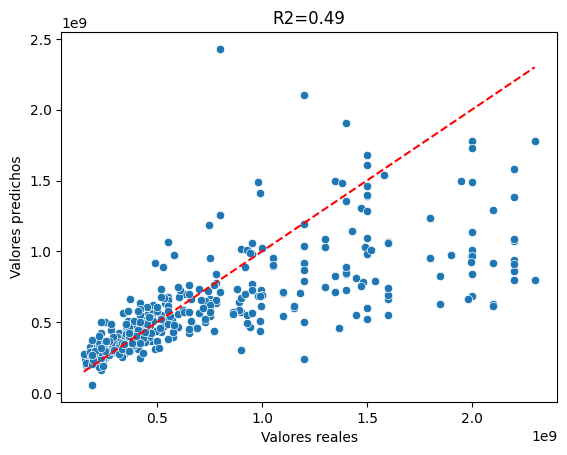

In [63]:
sns.scatterplot(x=y_test, y=y_pred_svr)
sns.lineplot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='r', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title(f'R2={r2_score(y_test, y_pred_svr):.2f}')
plt.show()
plt.show()

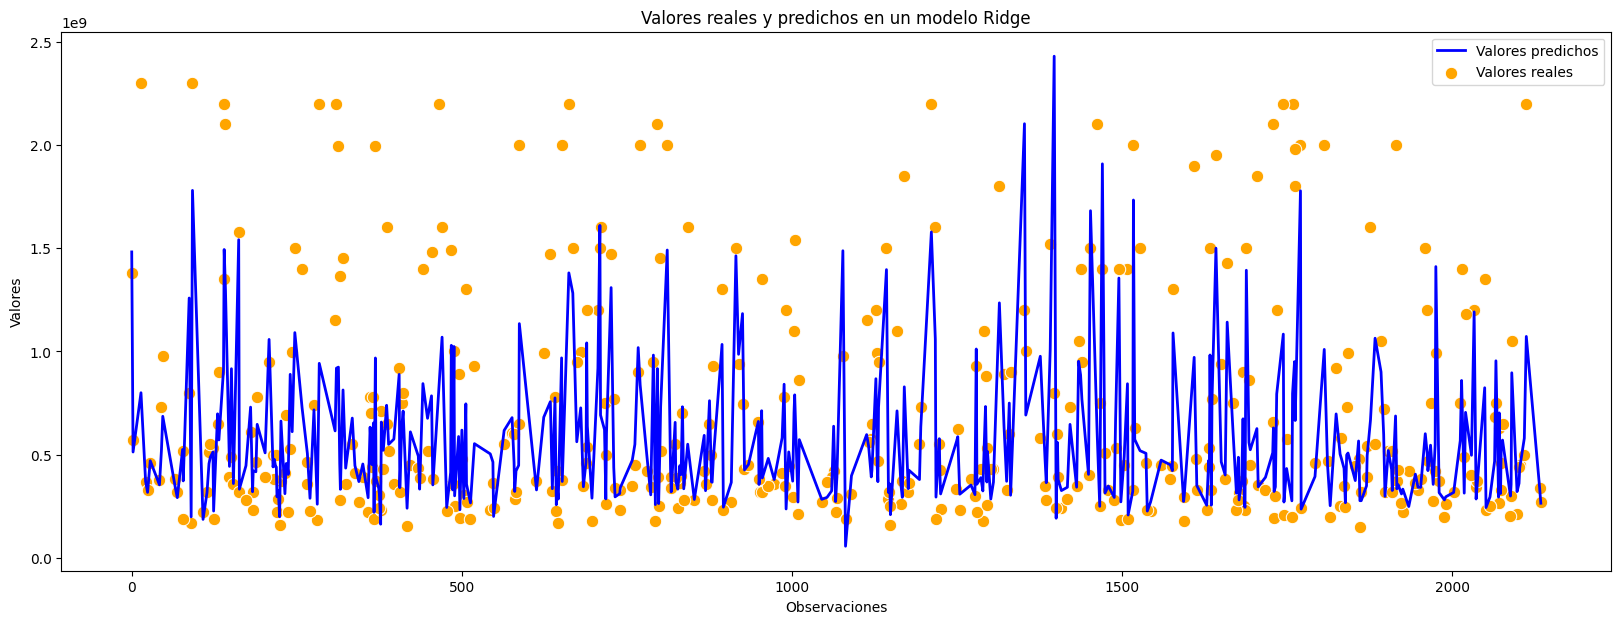

In [64]:
plt.figure(figsize=(20, 7))
df_grafica_test = pd.DataFrame({'Valores reales': y_test, 'Valores predichos': y_pred_svr})
sns.lineplot(x=df_grafica_test.index, y='Valores predichos', data=df_grafica_test, linewidth=2, color='blue')
sns.scatterplot(x=df_grafica_test.index, y='Valores reales', data=df_grafica_test,  s=80, color='orange')
plt.title('Valores reales y predichos en un modelo Ridge')
plt.xlabel('Observaciones')
plt.ylabel('Valores')
plt.legend(labels=['Valores predichos', 'Valores reales'])

# Conslusion Regresion de soporte de vectores (SVR)

Se encontro mediante validacion cruzada que el mejor modelo para un arbol de regresion tiene los siguientes parametros:
* R2: 0.4911
* MSE: 1.480206e+17
* RMSE: 3.847345e+08
* AbsoluteMSE: 2.203294e+08
* Varianza explicada: 0.5423

De este modelo se pueden concluir tres aspectos:
1. Se observa que el modelo tuvo peor rendimiento fuera de muestra, esto se puede deducir debido a que se utilizo un kernel polinomial, que por lo general se ajustan mucho a los datos y no generalizan bien.
2. Se observa una metricas con un mal desempeño siendo el peor desempeño de los 3 metodos utilizados.
3. Se puede decir que la maquina de vectores de soporte tenga mejor rendimiento para problemas de clasificacion que para problemas de regresion.
